In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.utils)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd import eop_analytical, eop_simulation
from endoutbreakvbd.chikungunya import get_data, get_parameters, get_weather_data
from endoutbreakvbd.inference import fit_weather_model
from endoutbreakvbd.utils import month_start_xticks

In [3]:
df = get_data()
df_weather = get_weather_data()
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
rep_no_func = parameters["rep_no_func"]
rep_no_func_doy = parameters["rep_no_func_doy"]

rng = np.random.default_rng(2)

In [4]:
doy_start = df["doy"].to_numpy()[0]
incidence_vec = np.append(df["cases"].to_numpy(), np.zeros(30))
doy_vec = np.arange(doy_start, doy_start + len(incidence_vec))
temperature_vec = (
    df_weather.reset_index().set_index("doy").reindex(doy_vec)["temperature"].to_numpy()
)

In [5]:
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

dp = DeterministicProcess(
    index=df_weather.index,
    constant=True,
    additional_terms=[Fourier(order=2, period=365)],
    drop=True,
)
X = dp.in_sample()  # DataFrame with sin/cos columns + intercept
y = df_weather["temperature"].loc[X.index]
model = OLS(y, X).fit()
df_weather_smoothed = pd.DataFrame(
    {"doy": X.index.dayofyear, "temperature": model.fittedvalues},
    index=X.index,
)
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     747.2
Date:                Tue, 04 Nov 2025   Prob (F-statistic):          7.26e-173
Time:                        17:34:22   Log-Likelihood:                -828.81
No. Observations:                 365   AIC:                             1668.
Df Residuals:                     360   BIC:                             1687.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.3688      0.124    132.508      0.0

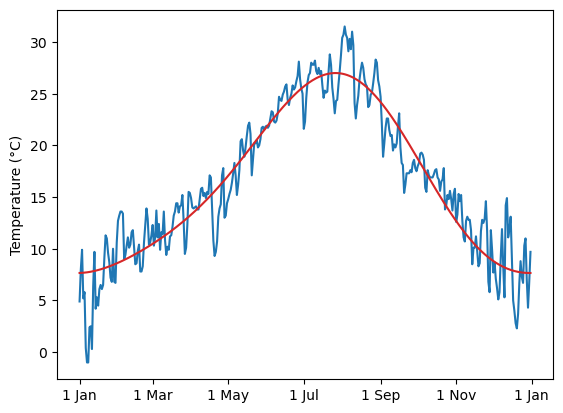

In [6]:
# df_weather_smoothed = (
#     df_weather[["temperature"]].rolling(window=14, center=False).mean()
# )
# df_weather_smoothed["doy"] = df_weather_smoothed.index.dayofyear
temperature_vec_smoothed = (
    df_weather_smoothed.reset_index()
    .set_index("doy")
    .reindex(doy_vec)["temperature"]
    .to_numpy()
)


fig, ax = plt.subplots()
ax.plot(
    df_weather["doy"],
    df_weather["temperature"],
    color="tab:blue",
)
ax.plot(
    df_weather_smoothed["doy"],
    df_weather_smoothed["temperature"],
    color="tab:red",
)

month_start_xticks(ax, interval_months=2)
ax.set_ylabel("Temperature (°C)");

In [7]:
df_weather_smoothed["temperature"].idxmax().dayofyear

208

In [8]:
idata = fit_weather_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
    # temperature_vec=temperature_vec,
    temperature_vec=temperature_vec_smoothed,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rep_no_max, c_0, c_1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'rep_no_max'}>,
        <Axes: title={'center': 'rep_no_max'}>],
       [<Axes: title={'center': 'c_0'}>, <Axes: title={'center': 'c_0'}>],
       [<Axes: title={'center': 'c_1'}>, <Axes: title={'center': 'c_1'}>]],
      dtype=object)

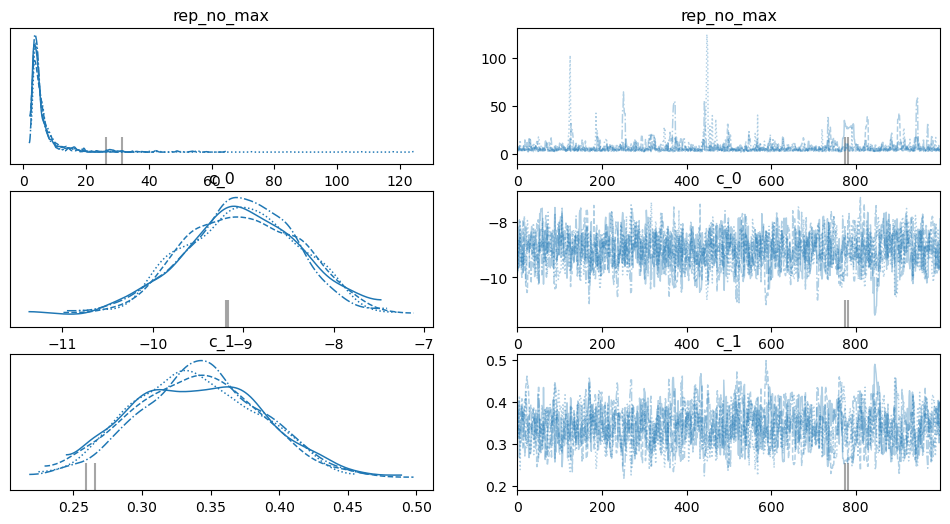

In [9]:
az.plot_trace(idata, var_names=["rep_no_max", "c_0", "c_1"])

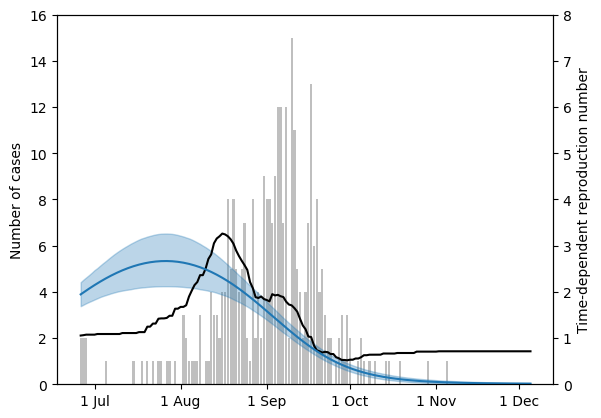

In [10]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df.doy, df["cases"], color="gray", alpha=0.5)
ax2.plot(doy_vec, rep_no_func_doy(doy_vec), color="black")
ax2.plot(
    doy_vec,
    idata.posterior["rep_no_vec"].mean(dim=["chain", "draw"]),
    color="tab:blue",
)
ax2.fill_between(
    doy_vec,
    np.percentile(idata.posterior["rep_no_vec"].values, 2.5, axis=(0, 1)),
    np.percentile(idata.posterior["rep_no_vec"].values, 97.5, axis=(0, 1)),
    color="tab:blue",
    alpha=0.3,
)
# ax2.plot(df.doy, rep_no_func_doy_estim(df.doy), "--", color="tab:red")

month_start_xticks(ax, interval_months=1)
ax.set_ylim(0, 16)
ax2.set_ylim(0, 8)
ax.set_ylabel("Number of cases")
ax2.set_ylabel("Time-dependent reproduction number");